# Multi-level Orchestration Evaluation Metric (MOEM)

SAOP WORKFLOW ORCHESTRATION EVALUATION SUMMARY
Total Commands Evaluated: 240
Invalid Cycles - Mean: 0.14, Max: 3, Zero Invalid Rate: 91.7%

WORKFLOW STAGE ACCURACIES:
----------------------------------------
speech_to_text      : 0.738 (95% CI: 0.681-0.794)
command_correction  : 0.983 (95% CI: 0.967-1.000)
command_reasoning   : 0.983 (95% CI: 0.967-1.000)
action_determination: 0.958 (95% CI: 0.933-0.984)
orchestration_flow  : 1.000 (95% CI: 1.000-1.000)

FINAL RESULTS:
----------------------------------------
Strict Success      : 0.658
Multi-pass Success  : 0.958
Single-pass Success : 0.892

WORKFLOW ANALYSIS


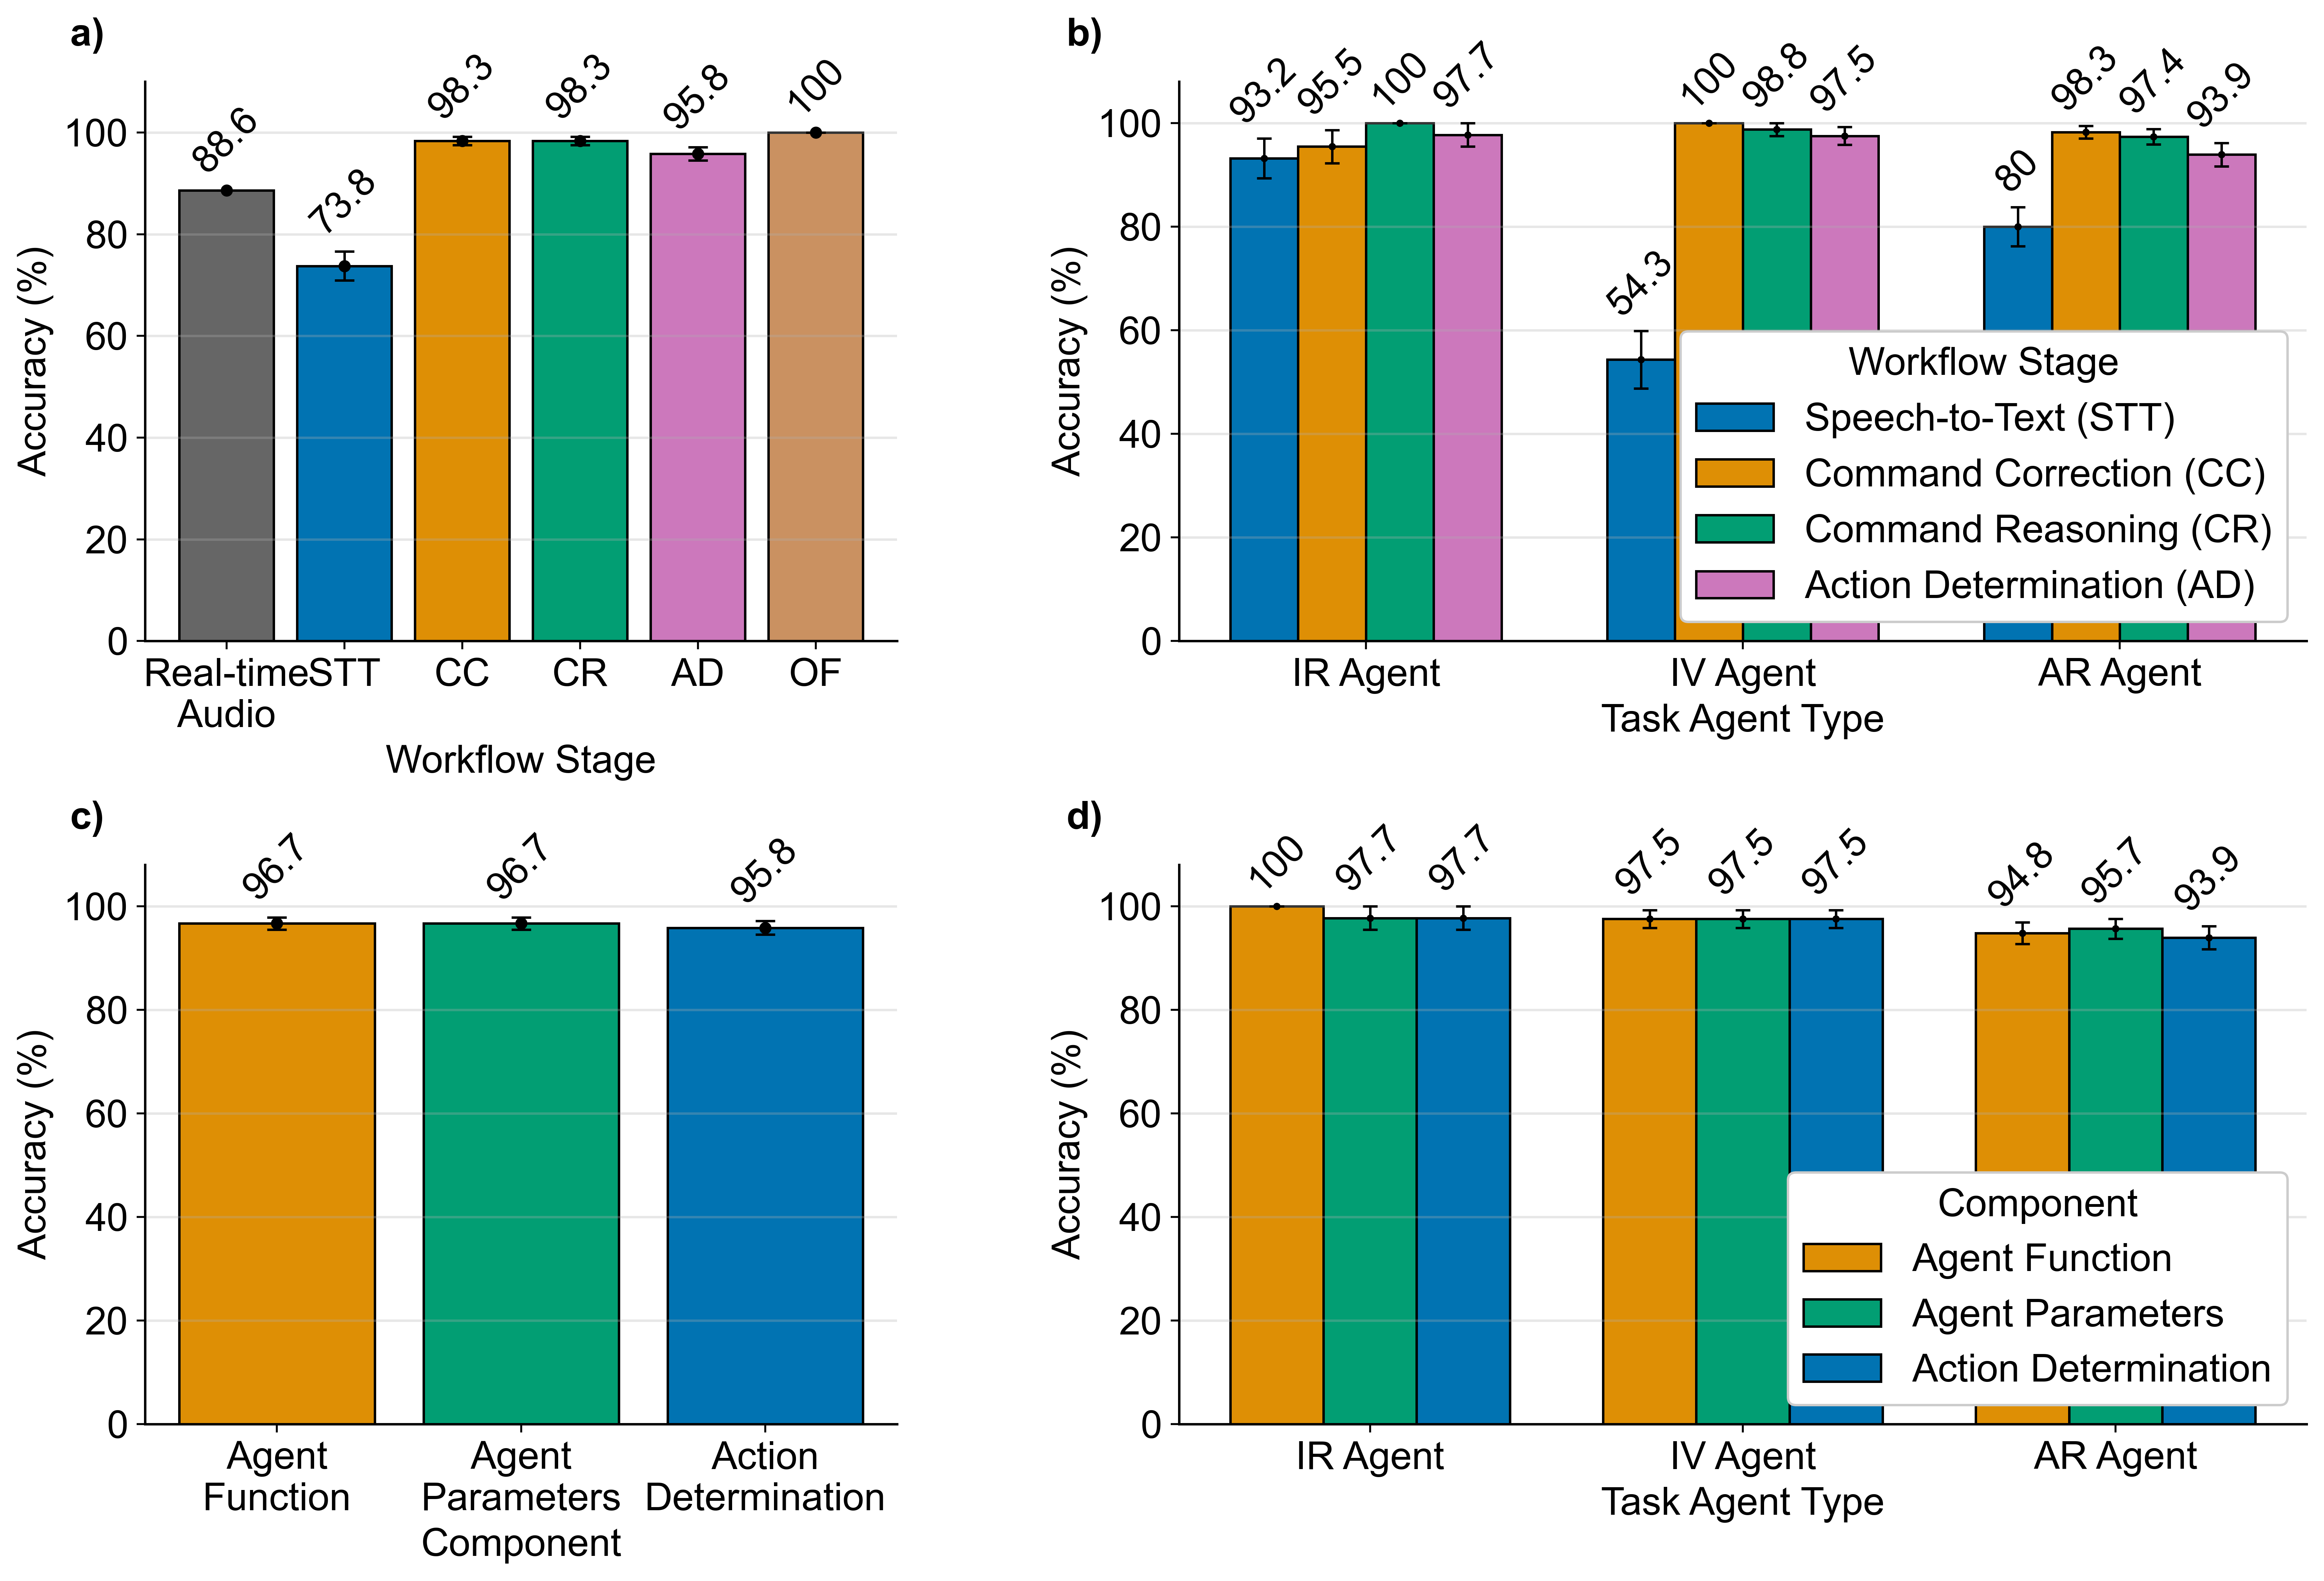

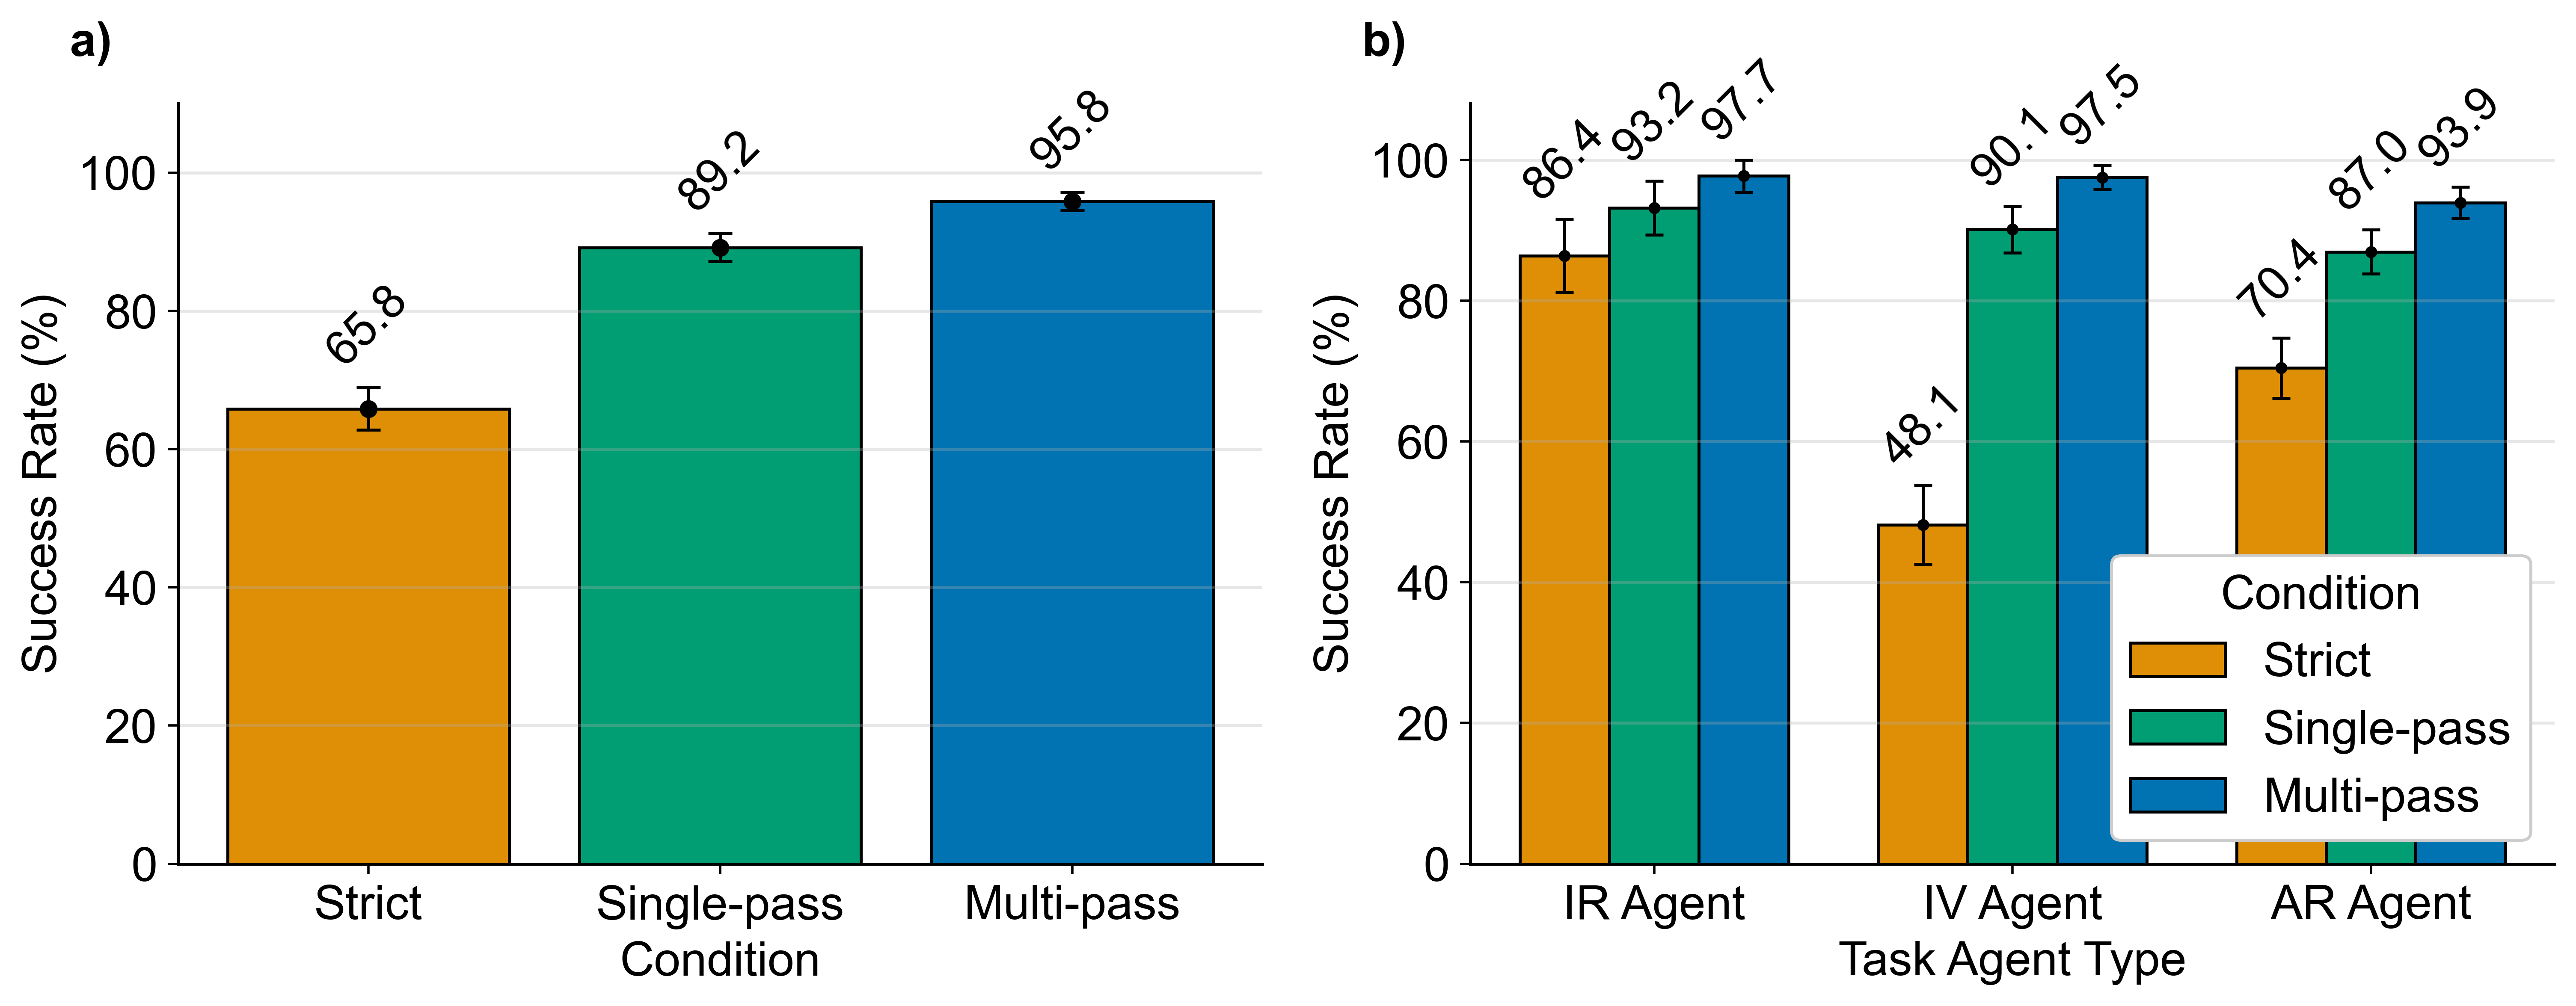


COMMAND CATEGORY ANALYSIS

🔹 Command Structure Performance:
----------------------------------------
Single                             : 0.969 (218/225) [95% CI: 0.946-0.992]
Composite                          : 0.800 (12/15) [95% CI: 0.571-1.029]


🔹 Command Type Performance:
----------------------------------------
Explicit                           : 0.975 (78/80) [95% CI: 0.940-1.010]
NLQ                                : 0.950 (76/80) [95% CI: 0.901-0.999]
Implicit                           : 0.950 (76/80) [95% CI: 0.901-0.999]


🔹 Command Expressions Performance:
----------------------------------------
Abbreviation                       : 1.000 (15/15) [95% CI: 1.000-1.000]
Baseline                           : 0.972 (141/145) [95% CI: 0.945-0.999]
Paraphrase                         : 0.925 (74/80) [95% CI: 0.866-0.984]



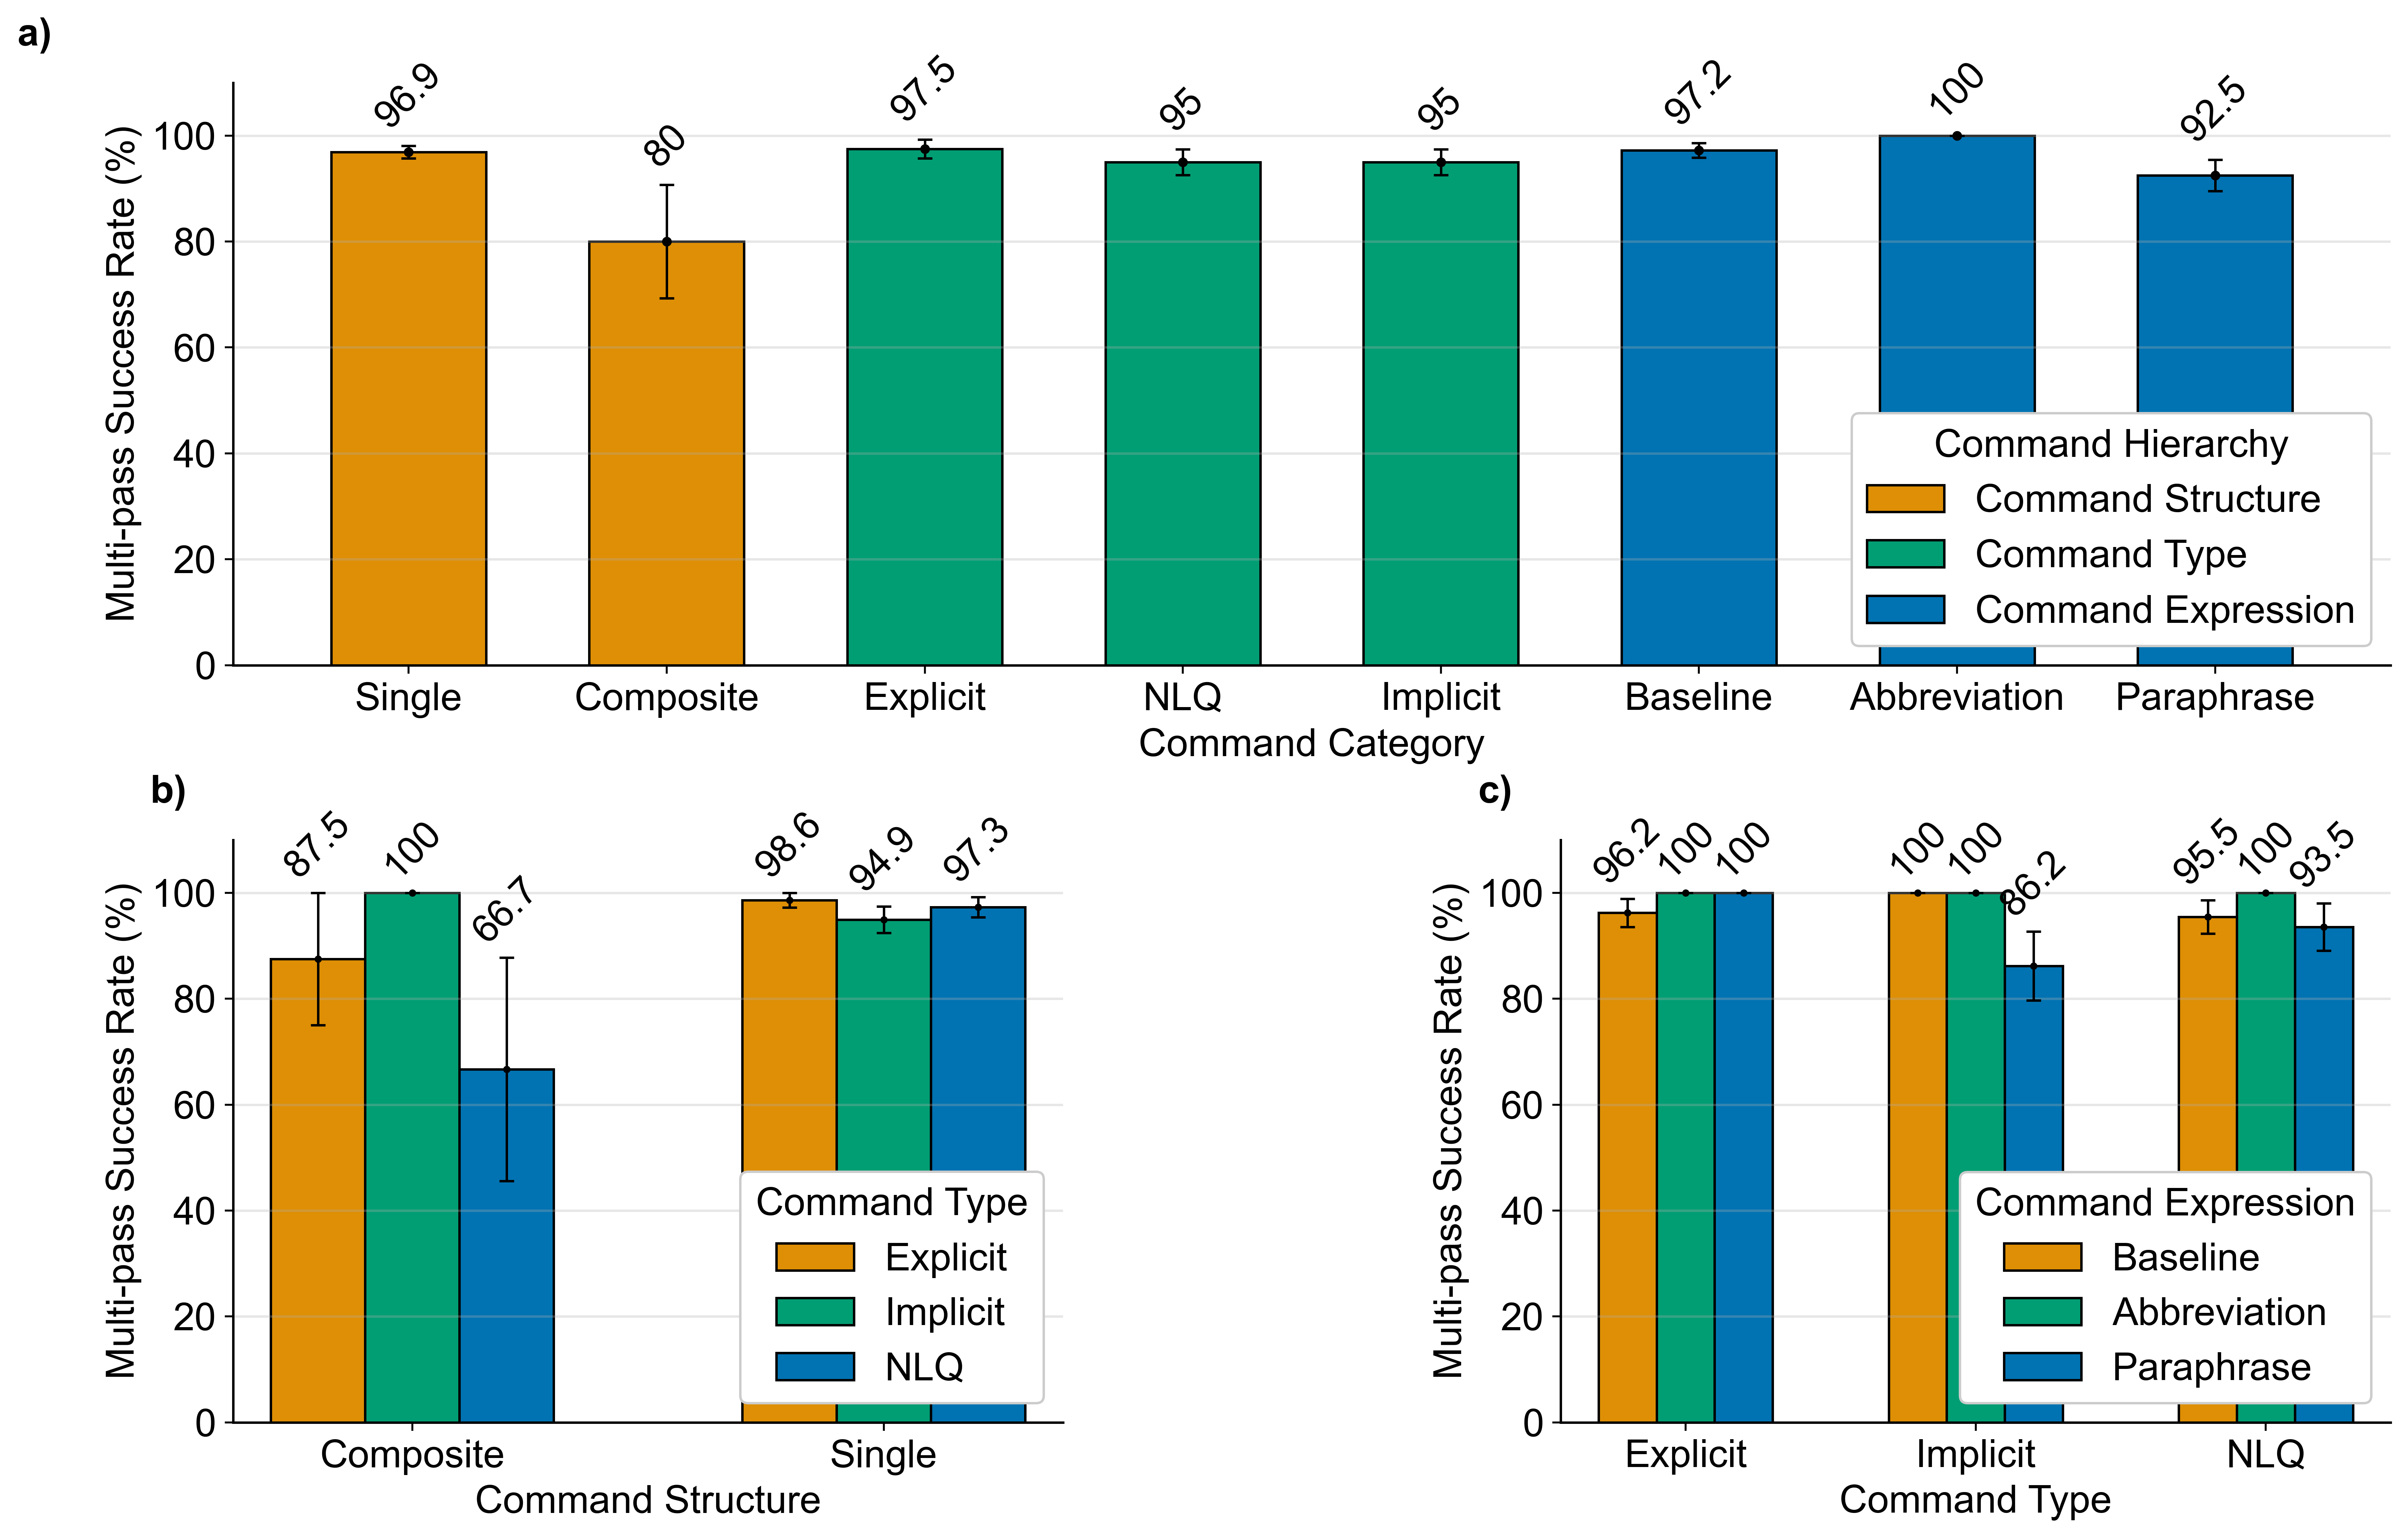

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from scipy import stats
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings('ignore')

# Global settings: consistent fonts and styles
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica', 'Arial', 'DejaVu Sans']
plt.rcParams['font.size'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.dpi'] = 500
plt.rcParams['lines.linewidth'] = 1.0
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['grid.linewidth'] = 1.0

# Colorblind-friendly palette (turquoise-yellow-magenta)
COLORBLIND_PALETTE = {
    'blue': '#0173B2',
    'orange': '#DE8F05', 
    'teal': '#029E73',
    'magenta': '#CC78BC',
    'brown': '#CA9161',
    'lightblue': '#56B4E9',
    'darkblue': '#004C99'
}

def format_value(val):
    """Format 100.0 as 100"""
    if pd.isna(val) or np.isnan(val):
        return ""
    if val == int(val):
        return f"{int(val)}"
    return f"{val:.1f}"

def shorten_category_name(name):
    """Shorten category names"""
    name_mapping = {
        'Single Command': 'Single',
        'Composite commands': 'Composite',
        'Explicit & Complete Command': 'Explicit',
        'Natural Language Question': 'NLQ',
        'Implicit & Incomplete Command': 'Implicit',
        'Baseline Expressions': 'Baseline',
        'Commands with synonym/paraphrased expression': 'Paraphrase',
        'Commands with abbreviations (General & Domain Terms)': 'Abbreviation'
    }
    return name_mapping.get(name, name)

class SAOPEvaluationFramework:
    """SAOP (Speech-Assistant Orchestration Platform) Workflow Evaluation Framework"""
    
    def __init__(self, data_path, sheet_name="all_commands"):
        self.df = pd.read_excel(data_path, sheet_name=sheet_name)
        self.workflow_stages = [
            "speech_to_text", "command_correction", "command_reasoning", 
            "agent_function", "agent_parameters", "orchestration_flow"
        ]
        self.core_stages = ["command_reasoning", "agent_function", "agent_parameters", "orchestration_flow"]
        
        # Agent name mapping (internal data → visualization display)
        self.agent_display_names = {
            "IR agent": "IR Agent",  # Information Retrieval
            "IV Agent": "IV Agent",  # Image Viewer
            "AR Agent": "AR Agent"   # Anatomy Renderer
        }
        
        self.prepare_data()
        
    def prepare_data(self):
        """Data preprocessing and metric calculation"""
        # Convert to numeric
        for col in self.workflow_stages:
            self.df[col] = pd.to_numeric(self.df[col], errors="coerce")

        # Keep agent name as is (already in correct format)
        self.df['agent_type'] = self.df['agent']
        
        # Preprocess command categories
        self._prepare_command_categories()
        
        # Calculate success metrics
        self._calculate_success_metrics()
        
        # Handle invalid cycle
        if "invalid_cycle" not in self.df.columns:
            self.df["invalid_cycle"] = 0
        
        # Calculate statistics
        self.calculate_statistics()

    def _prepare_command_categories(self):
        """Preprocess command category data"""
        # Excel already has clean, short names - just use them directly
        self.df['command_structure_clean'] = self.df['structure']
        self.df['command_type_clean'] = self.df['type']
        self.df['command_expressions_clean'] = self.df['expression']
        
    def _calculate_success_metrics(self):
        """Calculate all success metrics at once"""
        # Unified workflow stage definition
        self.workflow_stages = [
            "speech_to_text", 
            "command_correction", 
            "command_reasoning", 
            "action_determination",
            "orchestration_flow"
        ]

        # Create unified stage
        self.df["action_determination"] = np.logical_and(
            self.df["agent_function"] == 1,
            self.df["agent_parameters"] == 1
        ).astype(int)

        if "invalid_cycle" not in self.df.columns:
            self.df["invalid_cycle"] = 0

        # Strict success: all stages successful
        all_stages = ['speech_to_text', 'command_correction', 'command_reasoning',
                    'action_determination', 'orchestration_flow']
        self.df["strict_success"] = (np.logical_and.reduce([self.df[stage] == 1 for stage in all_stages]) & (self.df["invalid_cycle"] == 0)).astype(int)

        # Multi-pass success: core stages after Reasoning
        core_stages = ['command_reasoning', 'action_determination', 'orchestration_flow']
        self.df["multipass_success"] = np.logical_and.reduce([self.df[stage] == 1 for stage in core_stages]).astype(int)

        # Single-pass success
        self.df["singlepass_success"] = ((self.df["multipass_success"] == 1) & (self.df["invalid_cycle"] == 0)).astype(int)

        # Aliases
        self.df["strict_final"] = self.df["strict_success"]
        self.df["multipass_final"] = self.df["multipass_success"]
    
    def calculate_statistics(self):
        """Calculate evaluation metric statistics"""
        success_metrics = ["strict_success", "multipass_success", "singlepass_success"]
        all_metrics = self.workflow_stages + success_metrics
        
        # Basic statistics
        self.metrics = {}
        for metric in all_metrics:
            self.metrics[metric] = self._calculate_metric_stats(self.df[metric])
        
        # Invalid cycle statistics
        self.invalid_stats = {
            'mean_cycles': self.df['invalid_cycle'].mean(),
            'median_cycles': self.df['invalid_cycle'].median(),
            'max_cycles': self.df['invalid_cycle'].max(),
            'zero_invalid_ratio': (self.df['invalid_cycle'] == 0).mean()
        }
        
    def _calculate_metric_stats(self, series):
        """Calculate individual metric statistics (including standard error)"""
        return {
            'accuracy': series.mean(),
            'success_count': series.sum(),
            'total_count': len(series),
            'std_error': stats.sem(series),
            'confidence_interval': self._calculate_confidence_interval(series)
        }
        
    def _calculate_confidence_interval(self, data, confidence=0.95):
        """Calculate 95% confidence interval"""
        n = len(data)
        mean = data.mean()
        se = stats.sem(data)
        h = se * stats.t.ppf((1 + confidence) / 2., n-1)
        return (mean - h, mean + h)
    
    def _add_subplot_label(self, ax, label, x=-0.1, y=1.05):
        """Add label to top left of subplot (a), b), c), etc.)"""
        ax.text(x, y, label, fontsize=16, fontweight='bold', 
                ha='left', va='bottom', transform=ax.transAxes)
    
    def print_summary_statistics(self):
        """Print summary statistics"""
        print("="*60)
        print("SAOP WORKFLOW ORCHESTRATION EVALUATION SUMMARY")
        print("="*60)
        print(f"Total Commands Evaluated: {len(self.df)}")
        print(f"Invalid Cycles - Mean: {self.invalid_stats['mean_cycles']:.2f}, "
              f"Max: {self.invalid_stats['max_cycles']}, "
              f"Zero Invalid Rate: {self.invalid_stats['zero_invalid_ratio']:.1%}")
        print()
        
        self._print_stage_accuracies()
        self._print_final_results()
        
    def _print_stage_accuracies(self):
        """Print workflow stage accuracies"""
        print("WORKFLOW STAGE ACCURACIES:")
        print("-" * 40)
        for stage in self.workflow_stages:
            acc = self.metrics[stage]['accuracy']
            ci = self.metrics[stage]['confidence_interval']
            print(f"{stage:20s}: {acc:.3f} (95% CI: {ci[0]:.3f}-{ci[1]:.3f})")
        
    def _print_final_results(self):
        """Print final results"""
        print("\nFINAL RESULTS:")
        print("-" * 40)
        strict_acc = self.metrics['strict_success']['accuracy']
        multipass_acc = self.metrics['multipass_success']['accuracy']
        singlepass_acc = self.metrics['singlepass_success']['accuracy']
        
        print(f"{'Strict Success':<20s}: {strict_acc:.3f}")
        print(f"{'Multi-pass Success':<20s}: {multipass_acc:.3f}")
        print(f"{'Single-pass Success':<20s}: {singlepass_acc:.3f}")

    def analyze_agent_performance(self):
        """Analyze performance by agent"""
        agg_dict = {
            'strict_success': ['mean', 'sum', 'count'],
            'multipass_success': ['mean', 'sum'],
            'singlepass_success': ['mean', 'sum'],
        }
        
        for stage in self.workflow_stages:
            agg_dict[stage] = 'mean'
            
        agent_stats = self.df.groupby('agent_type').agg(agg_dict).round(3)
        agent_stats.columns = ['_'.join(col).strip() for col in agent_stats.columns]
        
        return agent_stats

    def plot_integrated_summary(self, figsize=(16, 10)):
        """Integrated visualization: Stage Accuracy + Action Determination (4 subplots)"""
        
        # ========== Data preparation ==========
        # Stage Accuracy data
        realtime_audio_acc = 0.886
        workflow_metrics = [self.metrics[stage]['accuracy'] * 100 for stage in self.workflow_stages]
        workflow_se = [self.metrics[stage]['std_error'] * 100 for stage in self.workflow_stages]
        
        workflow_metrics = [realtime_audio_acc * 100] + workflow_metrics
        workflow_se = [0] + workflow_se
        
        stages = ["Real-time\nAudio", "STT", "CC", "CR", "AD", "OF"]
        
        # Full stage names (for legend)
        full_stage_names = [
            "Speech-to-Text (STT)",
            "Command Correction (CC)",
            "Command Reasoning (CR)",
            "Action Determination (AD)",
        ]

        all_stage_colors = ['#666666', COLORBLIND_PALETTE['blue'], COLORBLIND_PALETTE['orange'], 
                        COLORBLIND_PALETTE['teal'], COLORBLIND_PALETTE['magenta'], 
                        COLORBLIND_PALETTE['brown']]
        stage_colors = all_stage_colors[1:5]  # Exclude OF (4 only)

        agent_order = ["IR agent", "IV Agent", "AR Agent"]
        
        # Stage Accuracy - by agent
        workflow_performance = (
            self.df.groupby("agent_type")[self.workflow_stages]
            .agg(['mean', 'sem'])
        )
        agent_means_stage = workflow_performance.xs('mean', axis=1, level=1).reindex(agent_order) * 100
        agent_se_stage = workflow_performance.xs('sem', axis=1, level=1).reindex(agent_order) * 100

        # Action Determination data
        df = self.df.copy()
        
        func_only = (df['agent_function'] == 1).mean() * 100
        param_only = (df['agent_parameters'] == 1).mean() * 100
        both = ((df['agent_function'] == 1) & (df['agent_parameters'] == 1)).mean() * 100
        
        func_se = stats.sem(df['agent_function']) * 100
        param_se = stats.sem(df['agent_parameters']) * 100
        both_se = stats.sem((df['agent_function'] == 1) & (df['agent_parameters'] == 1)) * 100

        action_labels = ["Agent\nFunction", "Agent\nParameters", "Action\nDetermination"]
        action_values = [func_only, param_only, both]
        action_errors = [func_se, param_se, both_se]
        action_colors = [COLORBLIND_PALETTE['orange'], COLORBLIND_PALETTE['teal'], 
                        COLORBLIND_PALETTE['blue']]

        # Action Determination - by agent
        df['action_determination'] = (
            (df['agent_function'] == 1) & (df['agent_parameters'] == 1)
        ).astype(int)

        metrics = ['agent_function', 'agent_parameters', 'action_determination']
        agent_stats = df.groupby('agent_type')[metrics].agg(['mean', 'sem'])
        agent_means_action = agent_stats.xs('mean', axis=1, level=1).reindex(agent_order) * 100
        agent_se_action = agent_stats.xs('sem', axis=1, level=1).reindex(agent_order) * 100

        # ========== Create figure (2x2 layout) ==========
        fig = plt.figure(figsize=figsize)
        gs = fig.add_gridspec(2, 2, width_ratios=[1, 1.5], hspace=0.4, wspace=0.3)
        
        # a) Overall Stage-level Accuracy
        ax1 = fig.add_subplot(gs[0, 0])
        self._add_subplot_label(ax1, 'a)')
        
        bars = ax1.bar(range(len(stages)), workflow_metrics, 
                    color=all_stage_colors, edgecolor='black', linewidth=1.0,
                    yerr=workflow_se, capsize=4, error_kw={'linewidth': 1.0})
        
        for i, val in enumerate(workflow_metrics):
            ax1.plot(i, val, 'o', color='black', markersize=4, zorder=3)
            ax1.text(i, val + workflow_se[i] + 2, format_value(val), 
                    ha='center', va='bottom', rotation=45, fontsize=16)

        ax1.set_xticks(range(len(stages)))
        ax1.set_xticklabels(stages, ha="center")
        ax1.set_xlabel("Workflow Stage")
        ax1.set_ylabel("Accuracy (%)")
        ax1.set_ylim(0, 110)
        ax1.grid(axis="y", alpha=0.3, linewidth=1.0)
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)

        # b) Stage-level Accuracy by Task Agent Type
        ax2 = fig.add_subplot(gs[0, 1])
        self._add_subplot_label(ax2, 'b)')
        
        x = np.arange(len(agent_order))
        width = 0.18
        
        stage_labels = ["Speech-to-Text (STT)", "Command Correction (CC)", 
                    "Command Reasoning (CR)", "Action Determination (AD)"]
        
        for i, (stage, color, label) in enumerate(zip(self.workflow_stages[:4], stage_colors, stage_labels)):
            means = agent_means_stage[stage].values
            errors = agent_se_stage[stage].values
            
            bars = ax2.bar(x + i * width, means, width, label=label,
                        color=color, edgecolor='black', linewidth=1.0,
                        yerr=errors, capsize=3, error_kw={'linewidth': 1.0})
            
            for j, (val, err) in enumerate(zip(means, errors)):
                ax2.plot(x[j] + i * width, val, 'o', color='black', markersize=2, zorder=3)
                ax2.text(x[j] + i * width, val + err + 1.5, format_value(val),
                        ha='center', va='bottom', rotation=45, fontsize=16)

        ax2.set_xlabel("Task Agent Type")
        ax2.set_ylabel("Accuracy (%)")
        ax2.set_ylim(0, 108)
        ax2.set_xticks(x + width * 1.5)
        ax2.set_xticklabels([self.agent_display_names.get(a, a) for a in agent_order])
        
        # Add unified legend (includes all stages from a) and b))
        legend_handles = [plt.Rectangle((0,0),1,1, facecolor=color, edgecolor='black', linewidth=1.0) 
                        for color in stage_colors]
        ax2.legend(legend_handles, full_stage_names, bbox_to_anchor=(1, 0), 
                loc="lower right", framealpha=1.0, title='Workflow Stage', frameon=True, 
                       fancybox=True)
        
        ax2.grid(axis="y", alpha=0.3, linewidth=1.0)
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)

        # c) Overall Action Determination
        ax3 = fig.add_subplot(gs[1, 0])
        self._add_subplot_label(ax3, 'c)')
        
        bars = ax3.bar(action_labels, action_values, color=action_colors, 
                    edgecolor='black', linewidth=1.0,
                    yerr=action_errors, capsize=4, error_kw={'linewidth': 1.0})
        
        for i, (val, err) in enumerate(zip(action_values, action_errors)):
            ax3.plot(i, val, 'o', color='black', markersize=4, zorder=3)
            ax3.text(i, val + err + 2, format_value(val), ha='center', va='bottom', rotation=45, fontsize=16)

        ax3.set_xlabel("Component")
        ax3.set_ylabel("Accuracy (%)")
        ax3.set_ylim(0, 108)
        ax3.grid(axis='y', alpha=0.3, linewidth=1.0)
        ax3.spines['top'].set_visible(False)
        ax3.spines['right'].set_visible(False)

        # d) Action Determination By Task Agent Type
        ax4 = fig.add_subplot(gs[1, 1])
        self._add_subplot_label(ax4, 'd)')
        
        x = np.arange(len(agent_order))
        width = 0.25
        
        metric_labels = ["Agent Function", "Agent Parameters", "Action Determination"]
        for i, (metric, color, label) in enumerate(zip(metrics, action_colors, metric_labels)):
            means = agent_means_action[metric].values
            errors = agent_se_action[metric].values
            
            bars = ax4.bar(x + i * width, means, width, label=label,
                        color=color, edgecolor='black', linewidth=1.0,
                        yerr=errors, capsize=3, error_kw={'linewidth': 1.0})
            
            for j, (val, err) in enumerate(zip(means, errors)):
                ax4.plot(x[j] + i * width, val, 'o', color='black', markersize=2, zorder=3)
                ax4.text(x[j] + i * width, val + err + 1.5, format_value(val),
                        ha='center', va='bottom', rotation=45, fontsize=16)
        
        ax4.set_xlabel("Task Agent Type")
        ax4.set_ylabel("Accuracy (%)")
        ax4.set_ylim(0, 108)
        ax4.set_xticks(x + width)
        ax4.set_xticklabels([self.agent_display_names.get(a, a) for a in agent_order])
        ax4.legend(bbox_to_anchor=(1, 0), loc='lower right', framealpha=1.0, frameon=True, fancybox=True, title='Component')
        ax4.grid(axis='y', alpha=0.3, linewidth=1.0)
        ax4.spines['top'].set_visible(False)
        ax4.spines['right'].set_visible(False)

        plt.tight_layout(rect=[0, 0, 0.92, 1])
        plt.show()

    def plot_workflow_success_rate(self, figsize=(14, 5), labels=('a)', 'b)')):
        """Workflow-level success rate visualization (overall + by task agent)"""
        # Data preparation (order changed: Strict, Single-pass, Multi-pass)
        final_labels = ["Strict", "Single-pass", "Multi-pass"]
        final_values = [
            self.metrics["strict_success"]["accuracy"] * 100,
            self.metrics["singlepass_success"]["accuracy"] * 100,
            self.metrics["multipass_success"]["accuracy"] * 100,
        ]
        final_se = [
            self.metrics["strict_success"]["std_error"] * 100,
            self.metrics["singlepass_success"]["std_error"] * 100,
            self.metrics["multipass_success"]["std_error"] * 100,
        ]
        
        agent_order = ["IR agent", "IV Agent", "AR Agent"]
        success_metrics = ["strict_success", "singlepass_success", "multipass_success"]
        
        agent_success = (
            self.df.groupby("agent_type")[success_metrics]
            .agg(['mean', 'sem'])
        )
        agent_means = agent_success.xs('mean', axis=1, level=1).reindex(agent_order) * 100
        agent_se = agent_success.xs('sem', axis=1, level=1).reindex(agent_order) * 100
        
        # Colorblind-friendly colors (order changed)
        colors = [COLORBLIND_PALETTE['orange'], COLORBLIND_PALETTE['teal'], 
                 COLORBLIND_PALETTE['blue']]
        
        # Create figure
        fig, axes = plt.subplots(1, 2, figsize=figsize, width_ratios=[1, 1])

        # (Left) Overall Success Rate
        ax1 = axes[0]
        if labels and labels[0]:
            self._add_subplot_label(ax1, labels[0])
        
        bars = ax1.bar(final_labels, final_values, color=colors, 
                      edgecolor='black', linewidth=1.0,
                      yerr=final_se, capsize=4, error_kw={'linewidth': 1.0})
        
        for i, (val, err) in enumerate(zip(final_values, final_se)):
            ax1.plot(i, val, 'o', color='black', markersize=5, zorder=3)
            ax1.text(i, val + err + 2, format_value(val), ha='center', va='bottom', rotation=45, fontsize=16)
        
        ax1.set_xlabel("Condition")
        ax1.set_ylabel("Success Rate (%)")
        ax1.set_ylim(0, 110)
        ax1.grid(axis="y", alpha=0.3, linewidth=1.0)
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)

        # (Right) Success Rate by Agent
        ax2 = axes[1]
        if labels and len(labels) > 1 and labels[1]:
            self._add_subplot_label(ax2, labels[1])
        
        x = np.arange(len(agent_order))
        width = 0.25
        
        for i, (metric, color, label) in enumerate(zip(success_metrics, colors, final_labels)):
            means = agent_means[metric].values
            errors = agent_se[metric].values
            
            bars = ax2.bar(x + i * width, means, width, label=label,
                          color=color, edgecolor='black', linewidth=1.0,
                          yerr=errors, capsize=3, error_kw={'linewidth': 1.0})
            
            for j, (val, err) in enumerate(zip(means, errors)):
                ax2.plot(x[j] + i * width, val, 'o', color='black', markersize=3, zorder=3)
                ax2.text(x[j] + i * width, val + err + 1.5, format_value(val),
                        ha='center', va='bottom', rotation=45, fontsize=16)
        
        ax2.set_ylabel("Success Rate (%)")
        ax2.set_xlabel("Task Agent Type")
        ax2.set_ylim(0, 108)
        ax2.set_xticks(x + width)
        ax2.set_xticklabels([self.agent_display_names.get(a, a) for a in agent_order])
        ax2.legend(bbox_to_anchor=(1, 0), loc="lower right", framealpha=1.0, frameon=True, fancybox=True, title='Condition')
        ax2.grid(axis="y", alpha=0.3, linewidth=1.0)
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)

        plt.tight_layout(rect=[0, 0, 0.88, 1])
        plt.show()

    def plot_workflow_flow(self, figsize=(16, 6), label='k)'):
        """Workflow stage-by-stage success/recovery/failure flow Sankey Diagram"""
        df = self.df.copy()
        total = len(df)

        # Data aggregation
        stt_success = (df["speech_to_text"] == 1).sum()
        stt_failure = (df["speech_to_text"] == 0).sum()
        
        # STT Success → Correction
        stt_to_corr_success = ((df["speech_to_text"]==1) & (df["command_correction"]==1)).sum()
        stt_to_corr_failure = ((df["speech_to_text"]==1) & (df["command_correction"]==0)).sum()
        
        # STT Failure → Correction
        sttf_to_corr_success = ((df["speech_to_text"]==0) & (df["command_correction"]==1)).sum()
        sttf_to_corr_failure = ((df["speech_to_text"]==0) & (df["command_correction"]==0)).sum()
        
        # Correction → Reasoning
        corr_to_reas_success = ((df["command_correction"]==1) & (df["command_reasoning"]==1)).sum()
        corr_to_reas_failure = ((df["command_correction"]==1) & (df["command_reasoning"]==0)).sum()
        
        corrf_to_reas_success = ((df["command_correction"]==0) & (df["command_reasoning"]==1)).sum()
        corrf_to_reas_failure = ((df["command_correction"]==0) & (df["command_reasoning"]==0)).sum()
        
        # Reasoning → Final (4 combinations)
        reas_to_final_11 = ((df["command_reasoning"]==1) & (df["agent_function"]==1) & (df["agent_parameters"]==1)).sum()
        reas_to_final_10 = ((df["command_reasoning"]==1) & (df["agent_function"]==1) & (df["agent_parameters"]==0)).sum()
        reas_to_final_01 = ((df["command_reasoning"]==1) & (df["agent_function"]==0) & (df["agent_parameters"]==1)).sum()
        reas_to_final_00 = ((df["command_reasoning"]==1) & (df["agent_function"]==0) & (df["agent_parameters"]==0)).sum()
        
        reasf_to_final_11 = ((df["command_reasoning"]==0) & (df["agent_function"]==1) & (df["agent_parameters"]==1)).sum()
        reasf_to_final_10 = ((df["command_reasoning"]==0) & (df["agent_function"]==1) & (df["agent_parameters"]==0)).sum()
        reasf_to_final_01 = ((df["command_reasoning"]==0) & (df["agent_function"]==0) & (df["agent_parameters"]==1)).sum()
        reasf_to_final_00 = ((df["command_reasoning"]==0) & (df["agent_function"]==0) & (df["agent_parameters"]==0)).sum()

        # Create Plotly Sankey
        node_labels = [
            "STT Success", "STT Failure",
            "Correction Success", "Correction Failure",
            "Reasoning Success", "Reasoning Failure",
            "Final: Func✓ Param✓", "Final: Func✓ Param✗",
            "Final: Func✗ Param✓", "Final: Func✗ Param✗"
        ]
        
        # Node colors
        node_colors = [
            '#7FC8C0',  # STT Success (turquoise)
            '#FF9966',  # STT Failure (orange)
            '#6B9BD1',  # Correction Success (blue)
            '#E8A5C5',  # Correction Failure (pink)
            '#A5D46A',  # Reasoning Success (lime green)
            '#FFD966',  # Reasoning Failure (yellow)
            '#B3B3B3',  # Final 1
            '#999999',  # Final 2
            '#808080',  # Final 3
            '#CC8800',  # Final 4
        ]
        
        source = []
        target = []
        value = []
        link_colors = []
        
        # STT → Correction
        if stt_to_corr_success > 0:
            source.append(0); target.append(2); value.append(stt_to_corr_success)
            link_colors.append('rgba(127, 200, 192, 0.3)')
        if stt_to_corr_failure > 0:
            source.append(0); target.append(3); value.append(stt_to_corr_failure)
            link_colors.append('rgba(127, 200, 192, 0.3)')
        if sttf_to_corr_success > 0:
            source.append(1); target.append(2); value.append(sttf_to_corr_success)
            link_colors.append('rgba(255, 153, 102, 0.3)')
        if sttf_to_corr_failure > 0:
            source.append(1); target.append(3); value.append(sttf_to_corr_failure)
            link_colors.append('rgba(255, 153, 102, 0.3)')
        
        # Correction → Reasoning
        if corr_to_reas_success > 0:
            source.append(2); target.append(4); value.append(corr_to_reas_success)
            link_colors.append('rgba(107, 155, 209, 0.3)')
        if corr_to_reas_failure > 0:
            source.append(2); target.append(5); value.append(corr_to_reas_failure)
            link_colors.append('rgba(107, 155, 209, 0.3)')
        if corrf_to_reas_success > 0:
            source.append(3); target.append(4); value.append(corrf_to_reas_success)
            link_colors.append('rgba(232, 165, 197, 0.3)')
        if corrf_to_reas_failure > 0:
            source.append(3); target.append(5); value.append(corrf_to_reas_failure)
            link_colors.append('rgba(232, 165, 197, 0.3)')
        
        # Reasoning → Final
        if reas_to_final_11 > 0:
            source.append(4); target.append(6); value.append(reas_to_final_11)
            link_colors.append('rgba(165, 212, 106, 0.3)')
        if reas_to_final_10 > 0:
            source.append(4); target.append(7); value.append(reas_to_final_10)
            link_colors.append('rgba(165, 212, 106, 0.3)')
        if reas_to_final_01 > 0:
            source.append(4); target.append(8); value.append(reas_to_final_01)
            link_colors.append('rgba(165, 212, 106, 0.3)')
        if reas_to_final_00 > 0:
            source.append(4); target.append(9); value.append(reas_to_final_00)
            link_colors.append('rgba(165, 212, 106, 0.3)')
            
        if reasf_to_final_11 > 0:
            source.append(5); target.append(6); value.append(reasf_to_final_11)
            link_colors.append('rgba(255, 217, 102, 0.3)')
        if reasf_to_final_10 > 0:
            source.append(5); target.append(7); value.append(reasf_to_final_10)
            link_colors.append('rgba(255, 217, 102, 0.3)')
        if reasf_to_final_01 > 0:
            source.append(5); target.append(8); value.append(reasf_to_final_01)
            link_colors.append('rgba(255, 217, 102, 0.3)')
        if reasf_to_final_00 > 0:
            source.append(5); target.append(9); value.append(reasf_to_final_00)
            link_colors.append('rgba(255, 217, 102, 0.3)')

        fig = go.Figure(go.Sankey(
            arrangement="snap",
            node=dict(
                pad=20,
                thickness=30,
                line=dict(color="black", width=0.5),
                label=node_labels,
                color=node_colors,
            ),
            link=dict(
                source=source,
                target=target,
                value=value,
                color=link_colors
            )
        ))

        fig.update_layout(
            title=dict(
                text="Workflow Flow Analysis" if not label else "",
                font=dict(size=20, family='Helvetica, Arial, sans-serif', weight='bold')
            ),
            font=dict(size=20, family='Helvetica, Arial, sans-serif'),
            height=500,
            width=1500,
            margin=dict(l=20, r=20, t=60, b=20)
        )
        
        # Add annotation for subplot label
        if label:
            fig.add_annotation(
                text=label,
                xref="paper", yref="paper",
                x=-0.05, y=1.05,
                showarrow=False,
                font=dict(size=14, family='Helvetica, Arial, sans-serif', weight='bold'),
                xanchor='left', yanchor='bottom'
            )
        
        fig.show()
        
    def generate_failure_analysis(self):
        """Failure analysis and error case typology"""
        print("\n" + "="*50)
        print("FAILURE ANALYSIS AND ERROR TYPOLOGY")
        print("="*50)
        
        failure_types = self._calculate_failure_types()
        
        print("Failure Type Distribution:")
        print("-" * 30)
        total_commands = len(self.df)
        for failure_type, count in failure_types.items():
            percentage = (count / total_commands) * 100
            print(f"{failure_type:<20s}: {count:3d} ({percentage:5.1f}%)")
        
        return failure_types
        
    def _calculate_failure_types(self):
        """Calculate number of cases by failure type"""
        return {
            'STT_Failure': (self.df['speech_to_text'] == 0).sum(),
            'Correction_Failure': ((self.df['speech_to_text'] == 1) & (self.df['command_correction'] == 0)).sum(),
            'Reasoning_Failure': ((self.df['command_correction'] == 1) & (self.df['command_reasoning'] == 0)).sum(),
            'Function_Failure': ((self.df['command_reasoning'] == 1) & (self.df['agent_function'] == 0)).sum(),
            'Parameter_Failure': ((self.df['agent_function'] == 1) & (self.df['agent_parameters'] == 0)).sum(),
            'Orchestration_Failure': ((self.df['agent_parameters'] == 1) & (self.df['orchestration_flow'] == 0)).sum()
        }
        
    def plot_invalid_analysis(self, figsize=(8, 5), label=None):
        """Visualize Invalid Cycle distribution"""
        cycle_counts = self.df['invalid_cycle'].value_counts().sort_index()

        fig, ax = plt.subplots(figsize=figsize)
        
        # Add subplot label
        if label:
            self._add_subplot_label(ax, label)
        
        bars = ax.bar(cycle_counts.index, cycle_counts.values, 
                      color=COLORBLIND_PALETTE['blue'], edgecolor='black', linewidth=1.0)
        
        ax.set_xlabel('Number of Invalid Cycles')
        ax.set_ylabel('Count')
        ax.grid(axis='y', alpha=0.3, linewidth=1.0)
        ax.set_xticks(cycle_counts.index.astype(int))

        for i, (idx, val) in enumerate(zip(cycle_counts.index, cycle_counts.values)):
            ax.plot(idx, val, 'o', color='black', markersize=4, zorder=3)
            ax.text(idx, val + 2, format_value(val), ha='center', va='bottom', rotation=45, fontsize=16)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        plt.tight_layout()
        plt.show()

    # ========== Command Category Analysis Methods ==========
    
    def analyze_command_categories(self):
        """Analyze performance by command category (Multi-pass Success basis)"""
        print("\n🔹 Command Structure Performance:")
        print("-" * 40)
        structure_stats = self._analyze_by_category('command_structure_clean')
        self._print_category_stats(structure_stats, 'Command Structure')

        print("\n🔹 Command Type Performance:")
        print("-" * 40)
        cmd_type_stats = self._analyze_by_category('command_type_clean')
        self._print_category_stats(cmd_type_stats, 'Command Type')
        
        print("\n🔹 Command Expressions Performance:")
        print("-" * 40)
        expr_stats = self._analyze_by_category('command_expressions_clean')
        self._print_category_stats(expr_stats, 'Command Expressions')
        
        return {
            'command_structure': structure_stats,
            'command_type': cmd_type_stats,
            'command_expressions': expr_stats,
        }
    
    def _analyze_by_category(self, category_field):
        """Analyze performance by category (Multi-pass Success basis)"""
        stats = {}
        
        for category in self.df[category_field].unique():
            category_data = self.df[self.df[category_field] == category]
            
            stats[category] = {
                'total': len(category_data),
                'multipass_success': category_data['multipass_success'].sum(),
                'multipass_accuracy': category_data['multipass_success'].mean(),
                'std_error': category_data['multipass_success'].sem(),
                'confidence_interval': self._calculate_confidence_interval(category_data['multipass_success'])
            }
            
        return stats
    
    def _print_category_stats(self, stats, category_name):
        """Print category statistics (Multi-pass Success basis)"""
        sorted_stats = sorted(stats.items(), key=lambda x: x[1]['multipass_accuracy'], reverse=True)
        
        for category, stat in sorted_stats:
            ci = stat['confidence_interval']
            print(f"{category:<35s}: {stat['multipass_accuracy']:.3f} ({stat['multipass_success']}/{stat['total']}) "
                  f"[95% CI: {ci[0]:.3f}-{ci[1]:.3f}]")
        print()

    def plot_integrated_command_category_performance(self, figsize=(16, 10)):
        """Integrated Command Category visualization: Category Performance + Grouped Bars"""
        
        # Color palette
        COLORS = [COLORBLIND_PALETTE['orange'], COLORBLIND_PALETTE['teal'], 
                COLORBLIND_PALETTE['blue']]

        # ========== Data preparation ==========
        # Command Category Performance data
        all_categories, all_rates, all_errors, all_colors, all_labels = [], [], [], [], []

        # Command Structure
        structure_stats = self._analyze_by_category('command_structure_clean')
        for name, stat in structure_stats.items():
            all_categories.append(name)  # Already shortened in Excel
            all_rates.append(stat['multipass_accuracy'] * 100)
            all_errors.append(stat['std_error'] * 100)
            all_colors.append(COLORS[0])
            all_labels.append('Structure')

        # Command Type
        type_stats = self._analyze_by_category('command_type_clean')
        for name, stat in type_stats.items():
            all_categories.append(name)  # Already shortened in Excel
            all_rates.append(stat['multipass_accuracy'] * 100)
            all_errors.append(stat['std_error'] * 100)
            all_colors.append(COLORS[1])
            all_labels.append('Type')

        # Command Expressions
        expr_stats = self._analyze_by_category('command_expressions_clean')
        # Expression order - using actual names from Excel
        expr_order = ['Baseline', 'Abbreviation', 'Paraphrase']
        for name in expr_order:
            if name in expr_stats:
                stat = expr_stats[name]
                all_categories.append(name)  # Already shortened in Excel
                all_rates.append(stat['multipass_accuracy'] * 100)
                all_errors.append(stat['std_error'] * 100)
                all_colors.append(COLORS[2])
                all_labels.append('Expressions')

        # Grouped Bar data 1: Structure × Type
        df1 = (
            self.df.groupby(['command_structure_clean', 'command_type_clean'])
            .agg({'multipass_success': ['mean', 'sem']})
            .reset_index()
        )
        df1.columns = ['command_structure_clean', 'command_type_clean', 'mean', 'sem']
        df1['mean'] *= 100
        df1['sem'] *= 100

        # Grouped Bar data 2: Type × Expression
        df2 = (
            self.df.groupby(['command_type_clean', 'command_expressions_clean'])
            .agg({'multipass_success': ['mean', 'sem']})
            .reset_index()
        )
        df2.columns = ['command_type_clean', 'command_expressions_clean', 'mean', 'sem']
        df2['mean'] *= 100
        df2['sem'] *= 100
        
        # Expression order specified (using abbreviated names)
        expression_order = ['Baseline', 'Abbreviation', 'Paraphrase']

        # ========== Create figure (1 top, 2 bottom) ==========
        fig = plt.figure(figsize=figsize)
        gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], hspace=0.3, wspace=0.6)
        
        # a) Command Category Performance (top, full width)
        ax1 = fig.add_subplot(gs[0, :])
        self._add_subplot_label(ax1, 'a)')
        
        # Fixed bar width setting
        fixed_bar_width = 0.6
        
        bars = ax1.bar(range(len(all_categories)), all_rates, width=fixed_bar_width,
                    color=all_colors, edgecolor='black', linewidth=1.0,
                    yerr=all_errors, capsize=3, error_kw={'linewidth': 1.0})

        for i, (rate, err) in enumerate(zip(all_rates, all_errors)):
            ax1.plot(i, rate, 'o', color='black', markersize=3, zorder=3)
            ax1.text(i, rate + err + 2, format_value(rate), ha='center', va='bottom', rotation=45, fontsize=16)

        ax1.set_xticks(range(len(all_categories)))
        ax1.set_xticklabels(all_categories, ha='center')
        ax1.set_xlabel('Command Category')
        ax1.set_ylabel('Multi-pass Success Rate (%)')
        ax1.set_ylim(0, 110)
        ax1.grid(axis='y', alpha=0.3, linewidth=1.0)
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)

        legend_elements = [
            Patch(facecolor=COLORS[0], edgecolor='black', linewidth=1.0, label='Command Structure'),
            Patch(facecolor=COLORS[1], edgecolor='black', linewidth=1.0, label='Command Type'),
            Patch(facecolor=COLORS[2], edgecolor='black', linewidth=1.0, label='Command Expression')
        ]
        ax1.legend(handles=legend_elements, bbox_to_anchor=(1, 0), loc='lower right', framealpha=1.0, frameon=True, fancybox=True, title='Command Hierarchy')

        # b) Structure × Type (bottom left)
        ax2 = fig.add_subplot(gs[1, 0])
        self._add_subplot_label(ax2, 'b)')
        
        structures = df1['command_structure_clean'].unique()
        types = df1['command_type_clean'].unique()
        x = np.arange(len(structures))
        
        # Changed to fixed bar width
        width = fixed_bar_width / len(types)
        
        for i, cmd_type in enumerate(types):
            data = df1[df1['command_type_clean'] == cmd_type].set_index('command_structure_clean')
            data = data.reindex(structures)
            means = data['mean'].values
            errors = data['sem'].fillna(0).values
            
            bars = ax2.bar(x + i * width, means, width, label=cmd_type,
                        color=COLORS[i % len(COLORS)],
                        edgecolor='black', linewidth=1.0,
                        yerr=errors, capsize=3, error_kw={'linewidth': 1.0})
            
            for j, (val, err) in enumerate(zip(means, errors)):
                if not np.isnan(val) and val > 0:
                    ax2.plot(x[j] + i * width, val, 'o', color='black', markersize=2, zorder=3)
                    ax2.text(x[j] + i * width, val + err + 1.5, format_value(val),
                            ha='center', va='bottom', rotation=45, fontsize=16)

        ax2.set_xlabel('Command Structure')
        ax2.set_ylabel('Multi-pass Success Rate (%)')
        ax2.set_xticks(x + width * (len(types) - 1) / 2)
        ax2.set_xticklabels(structures)
        ax2.set_ylim(0, 110)
        ax2.grid(axis='y', alpha=0.3, linewidth=1.0)
        ax2.legend(title='Command Type', bbox_to_anchor=(1, 0), loc='lower right', framealpha=1.0, frameon=True, fancybox=True)
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)

        # c) Type × Expression (bottom right)
        ax3 = fig.add_subplot(gs[1, 1])
        self._add_subplot_label(ax3, 'c)')
        
        types2 = df2['command_type_clean'].unique()
        expressions = [expr for expr in expression_order if expr in df2['command_expressions_clean'].values]
        x = np.arange(len(types2))
        
        # Changed to fixed bar width
        width = fixed_bar_width / len(expressions)
        
        for i, expr in enumerate(expressions):
            data = df2[df2['command_expressions_clean'] == expr].set_index('command_type_clean')
            data = data.reindex(types2)
            means = data['mean'].values
            errors = data['sem'].fillna(0).values
            
            bars = ax3.bar(x + i * width, means, width, label=expr,
                        color=COLORS[i % len(COLORS)],
                        edgecolor='black', linewidth=1.0,
                        yerr=errors, capsize=3, error_kw={'linewidth': 1.0})
            
            for j, (val, err) in enumerate(zip(means, errors)):
                if not np.isnan(val) and val > 0:
                    ax3.plot(x[j] + i * width, val, 'o', color='black', markersize=2, zorder=3)
                    ax3.text(x[j] + i * width, val + err + 1.5, format_value(val),
                            ha='center', va='bottom', rotation=45, fontsize=16)

        ax3.set_xlabel('Command Type')
        ax3.set_ylabel('Multi-pass Success Rate (%)')
        ax3.set_xticks(x + width * (len(expressions) - 1) / 2)
        ax3.set_xticklabels(types2)
        ax3.set_ylim(0, 110)
        ax3.grid(axis='y', alpha=0.3, linewidth=1.0)
        ax3.legend(title='Command Expression', bbox_to_anchor=(1, 0), loc='lower right', framealpha=1.0, frameon=True, fancybox=True)
        ax3.spines['top'].set_visible(False)
        ax3.spines['right'].set_visible(False)

        plt.tight_layout(rect=[0, 0, 0.92, 1])
        plt.show()

    def print_decision_tree_text(self):
        """Print tree structure in text format"""
        df = self.df.copy()
        df['success_pct'] = df['multipass_success'] * 100
        
        # Excel already has short names, no need to map
        
        def get_stats(mask):
            s = df.loc[mask, 'success_pct']
            return float(s.mean()) if len(s) else 0, len(s)

        print("=" * 80)
        print("HIERARCHICAL SUCCESS RATE ANALYSIS")
        print("=" * 80)
        
        structures = sorted(df['command_structure_clean'].dropna().unique())
        for S in structures:
            mS = df['command_structure_clean'] == S
            rS, nS = get_stats(mS)
            print(f"\n📊 {S}: {format_value(rS)}% (n={nS})")
            print("─" * 80)
            
            types = sorted(df.loc[mS, 'command_type_clean'].dropna().unique())
            for T in types:
                mST = mS & (df['command_type_clean'] == T)
                rST, nST = get_stats(mST)
                delta_T = rST - rS
                arrow_T = "↑" if delta_T > 0 else "↓" if delta_T < 0 else "→"
                print(f"  ├─ {T}: {format_value(rST)}% (n={nST}) {arrow_T} {format_value(abs(delta_T))}%")
                
                exprs = sorted(df.loc[mST, 'command_expressions_clean'].dropna().unique())
                for i, E in enumerate(exprs):
                    mSTE = mST & (df['command_expressions_clean'] == E)
                    rSTE, nSTE = get_stats(mSTE)
                    delta_E = rSTE - rST
                    arrow_E = "↑" if delta_E > 0 else "↓" if delta_E < 0 else "→"
                    prefix = "  │  └─" if i == len(exprs) - 1 else "  │  ├─"
                    print(f"{prefix} {E}: {format_value(rSTE)}% (n={nSTE}) {arrow_E} {format_value(abs(delta_E))}%")
        
        print("\n" + "=" * 80)

# Usage example
if __name__ == "__main__":
    evaluator = SAOPEvaluationFramework("./datasets/SAOP_command_dataset_with_results.xlsx")
    
    # ===== Basic evaluation =====
    evaluator.print_summary_statistics()
    evaluator.analyze_agent_performance()
    
    # ===== Workflow analysis visualization =====
    print("\n" + "="*60)
    print("WORKFLOW ANALYSIS")
    print("="*60)
    evaluator.plot_integrated_summary()
    evaluator.plot_workflow_success_rate()
    evaluator.plot_workflow_flow()
    #evaluator.plot_invalid_analysis()
    
    # ===== Command Category analysis =====
    print("\n" + "="*60)
    print("COMMAND CATEGORY ANALYSIS")
    print("="*60)
    
    evaluator.analyze_command_categories()
    evaluator.plot_integrated_command_category_performance()
    #evaluator.print_decision_tree_text()

# Compare Synthesized Audio Datasets and Human voice

✓ Loaded AriaNeural: 240 commands
✓ Loaded JennyNeural: 240 commands
✓ Loaded GuyNeural: 240 commands
✓ Loaded ChristopherNeural: 240 commands
✓ Loaded Human voice: 240 commands

✓ Total combined data: 1200 commands across 5 voice types
MULTI-VOICE EVALUATION SUMMARY

📊 Stage-Level Accuracy (%):
----------------------------------------------------------------------
Voice               STT       CC        CR        AD        
----------------------------------------------------------------------
AriaNeural          96.7      97.5      98.3      92.5      
JennyNeural         93.8      95.8      96.7      90.8      
GuyNeural           96.7      97.1      97.9      93.3      
ChristopherNeural   92.5      95.4      96.7      90        
Human               73.8      98.3      98.3      95.8      
----------------------------------------------------------------------
Average             90.7      96.8      97.6      92.5      

📈 Success Rate Metrics (%):
----------------------------------

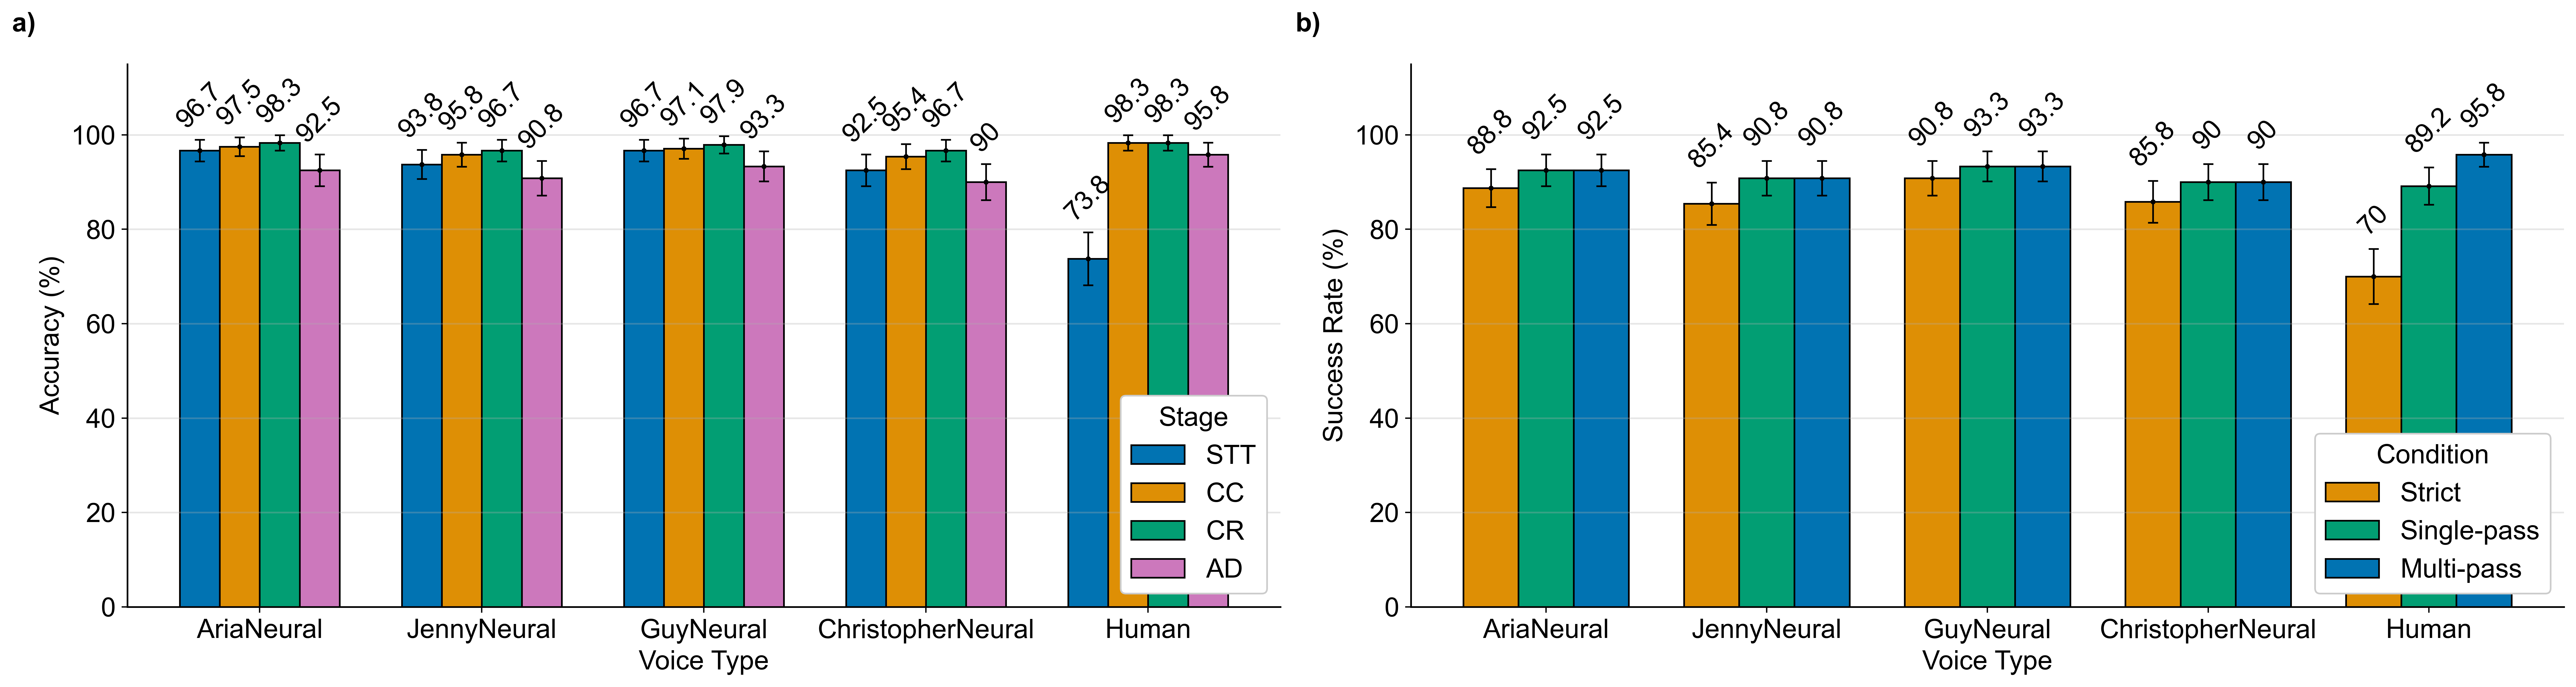

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, fisher_exact
import warnings
warnings.filterwarnings('ignore')

# Global settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica', 'Arial', 'DejaVu Sans']
plt.rcParams['font.size'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.dpi'] = 500
plt.rcParams['lines.linewidth'] = 1.0
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['grid.linewidth'] = 1.0

# Color palette
VOICE_COLORS = {
    'AriaNeural': '#0173B2',
    'JennyNeural': '#DE8F05',
    'GuyNeural': '#029E73',
    'ChristopherNeural': '#CC78BC',
    'Human': '#CA9161'  # brown - human voice
}

# Stage colors (Colorblind-friendly)
STAGE_COLORS = {
    'STT': '#0173B2',      # blue
    'CC': '#DE8F05',       # orange
    'CR': '#029E73',       # teal
    'AD': '#CC78BC',       # magenta
    'OF': '#CA9161'        # brown
}

# SR Type colors
SR_COLORS = {
    'Strict': '#DE8F05',       # orange
    'Single-pass': '#029E73',  # teal
    'Multi-pass': '#0173B2'    # blue
}

def format_value(val):
    """Format 100.0 as 100"""
    if pd.isna(val):
        return "N/A"
    if val == int(val):
        return f"{int(val)}"
    return f"{val:.1f}"


class MultiVoiceEvaluationFramework:
    """Multi-Voice Neural Integrated Analysis Framework (STT, CC, CR, AD, OF + Overall Workflow Success)"""
    
    def __init__(self, synthesized_data_path, human_data_path=None):
        """
        Args:
            synthesized_data_path: Path to Excel file with synthetic voices
            human_data_path: Path to Excel file with human voice (optional)
        """
        self.synthesized_data_path = synthesized_data_path
        self.human_data_path = human_data_path
        self.voice_names = ['AriaNeural', 'JennyNeural', 'GuyNeural', 'ChristopherNeural']
        self.synthetic_voices = ['AriaNeural', 'JennyNeural', 'GuyNeural', 'ChristopherNeural']
        
        # Add Human if human data path is provided
        if human_data_path:
            self.voice_names.append('Human')
        
        # Stage mapping (original column name -> abbreviated name)
        self.stage_mapping = {
            'speech_to_text': 'STT',
            'command_correction': 'CC',
            'command_reasoning': 'CR',
            'action_determination': 'AD',  # agent_function AND agent_parameters
            # 'orchestration_flow': 'OF'  # Excluded from visualization
        }
        
        self.load_and_prepare_data()
        
    def load_and_prepare_data(self):
        """Load and preprocess data (4 synthetic + 1 human if provided)"""
        self.dfs = {}
        self.all_data = []
        
        # Load synthetic voices
        for voice in self.synthetic_voices:
            sheet_name = f"all_commands_{voice}"
            try:
                df = pd.read_excel(self.synthesized_data_path, sheet_name=sheet_name)
                df['voice'] = voice
                df['voice_type'] = 'Synthetic'
                
                # Action Determination = agent_function AND agent_parameters
                if 'agent_function' in df.columns and 'agent_parameters' in df.columns:
                    df['action_determination'] = np.logical_and(
                        df['agent_function'] == 1,
                        df['agent_parameters'] == 1
                    ).astype(int)
                
                # Overall Workflow Success: all stages must succeed
                required_stages = ['speech_to_text', 'command_correction', 'command_reasoning',
                                 'action_determination', 'orchestration_flow']
                
                df['workflow_success'] = np.logical_and.reduce(
                    [df[stage] == 1 for stage in required_stages]
                ).astype(int)
                
                self.dfs[voice] = df
                self.all_data.append(df)
                print(f"✓ Loaded {voice}: {len(df)} commands")
                
            except Exception as e:
                print(f"✗ Error loading {voice}: {e}")
        
        # Load human voice if path is provided
        if self.human_data_path:
            try:
                df = pd.read_excel(self.human_data_path, sheet_name="all_commands")
                df['voice'] = 'Human'
                df['voice_type'] = 'Human'
                
                # Action Determination = agent_function AND agent_parameters
                if 'agent_function' in df.columns and 'agent_parameters' in df.columns:
                    df['action_determination'] = np.logical_and(
                        df['agent_function'] == 1,
                        df['agent_parameters'] == 1
                    ).astype(int)
                
                # Overall Workflow Success
                required_stages = ['speech_to_text', 'command_correction', 'command_reasoning',
                                 'action_determination', 'orchestration_flow']
                
                df['workflow_success'] = np.logical_and.reduce(
                    [df[stage] == 1 for stage in required_stages]
                ).astype(int)
                
                self.dfs['Human'] = df
                self.all_data.append(df)
                print(f"✓ Loaded Human voice: {len(df)} commands")
                
            except Exception as e:
                print(f"✗ Error loading Human voice: {e}")
        
        # Combine all data
        self.combined_df = pd.concat(self.all_data, ignore_index=True)
        print(f"\n✓ Total combined data: {len(self.combined_df)} commands across {len(self.dfs)} voice types")
        
        # Calculate success metrics
        self._calculate_success_metrics()
    
    def _calculate_success_metrics(self):
        """Calculate all success metrics at once"""
        for voice in self.voice_names:
            if voice not in self.dfs:
                continue
                
            df = self.dfs[voice]
            
            # Unified workflow stage definition
            self.workflow_stages = [
                "speech_to_text", 
                "command_correction", 
                "command_reasoning", 
                "action_determination",
                "orchestration_flow"
            ]
            
            # Strict success: all stages must succeed (already calculated as workflow_success)
            all_stages = ['speech_to_text', 'command_correction', 'command_reasoning',
                        'action_determination', 'orchestration_flow']
            df["strict_success"] = np.logical_and.reduce([df[stage] == 1 for stage in all_stages]).astype(int)
            
            # Multi-pass success: core stages after Reasoning
            core_stages = ['command_reasoning', 'action_determination', 'orchestration_flow']
            df["multipass_success"] = np.logical_and.reduce([df[stage] == 1 for stage in core_stages]).astype(int)
            
            # Single-pass success
            if "invalid_cycle" not in df.columns:
                df["invalid_cycle"] = 0
            df["singlepass_success"] = ((df["multipass_success"] == 1) & (df["invalid_cycle"] == 0)).astype(int)
            
            # Aliases
            df["strict_final"] = df["strict_success"]
            df["multipass_final"] = df["multipass_success"]
            
            self.dfs[voice] = df
    
    def calculate_stage_accuracy(self):
        """Calculate Stage Accuracy by voice"""
        results = []
        
        for voice in self.voice_names:
            if voice not in self.dfs:
                continue
                
            df = self.dfs[voice]
            row = {'Voice': voice}
            
            for stage_col, stage_name in self.stage_mapping.items():
                if stage_col in df.columns:
                    row[stage_name] = df[stage_col].mean() * 100
                else:
                    row[stage_name] = np.nan
            
            results.append(row)
        
        return pd.DataFrame(results)
    
    def calculate_all_success_rates(self):
        """Calculate Success Rate by voice (Strict, Single-pass, Multi-pass)"""
        results = []
        
        for voice in self.voice_names:
            if voice not in self.dfs:
                continue
                
            df = self.dfs[voice]
            row = {
                'Voice': voice,
                'Strict': df['strict_success'].mean() * 100 if 'strict_success' in df.columns else np.nan,
                'Single-pass': df['singlepass_success'].mean() * 100 if 'singlepass_success' in df.columns else np.nan,
                'Multi-pass': df['multipass_success'].mean() * 100 if 'multipass_success' in df.columns else np.nan
            }
            results.append(row)
        
        return pd.DataFrame(results)
    
    def calculate_confidence_intervals(self):
        """Calculate confidence intervals by voice (for both Stage and Success Rate)"""
        results = []
        
        for voice in self.voice_names:
            if voice not in self.dfs:
                continue
                
            df = self.dfs[voice]
            row = {'Voice': voice}
            
            # Confidence intervals by stage
            for stage_col, stage_name in self.stage_mapping.items():
                if stage_col in df.columns:
                    data = df[stage_col]
                    mean = data.mean() * 100
                    ci = self._calculate_confidence_interval(data)
                    row[f'{stage_name}_mean'] = mean
                    row[f'{stage_name}_ci_lower'] = ci[0] * 100
                    row[f'{stage_name}_ci_upper'] = ci[1] * 100
            
            # Confidence intervals by success rate
            for metric in ['Strict', 'Single-pass', 'Multi-pass']:
                metric_col = {
                    'Strict': 'strict_success',
                    'Single-pass': 'singlepass_success',
                    'Multi-pass': 'multipass_success'
                }[metric]
                
                if metric_col in df.columns:
                    data = df[metric_col]
                    mean = data.mean() * 100
                    ci = self._calculate_confidence_interval(data)
                    row[f'{metric}_mean'] = mean
                    row[f'{metric}_ci_lower'] = ci[0] * 100
                    row[f'{metric}_ci_upper'] = ci[1] * 100
            
            results.append(row)
        
        return pd.DataFrame(results)
    
    def _calculate_confidence_interval(self, data, confidence=0.95):
        """Calculate 95% confidence interval"""
        n = len(data)
        mean = data.mean()
        se = stats.sem(data)
        h = se * stats.t.ppf((1 + confidence) / 2., n-1)
        return (mean - h, mean + h)
    
    def perform_statistical_tests(self):
        """Perform statistical tests"""
        print("\n" + "="*70)
        print("STATISTICAL TESTS (Based on Multi-pass Success Rate)")
        print("="*70)
        
        # 1. Overall difference test across all voices (Chi-square test)
        print("\n1. Chi-square Test (Overall Difference Across All Voices)")
        print("-" * 70)
        
        # Based on multipass success
        contingency_table = []
        voice_labels = []
        
        for voice in self.voice_names:
            if voice not in self.dfs:
                continue
            df = self.dfs[voice]
            if 'multipass_success' in df.columns:
                success_count = df['multipass_success'].sum()
                failure_count = len(df) - success_count
                contingency_table.append([success_count, failure_count])
                voice_labels.append(voice)
        
        contingency_table = np.array(contingency_table)
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        
        print(f"Chi-square statistic: {chi2:.4f}")
        print(f"p-value: {p_value:.4f}")
        print(f"Degrees of freedom: {dof}")
        
        if p_value < 0.05:
            print("✓ Significant difference exists among voice types (p < 0.05)")
        else:
            print("✗ No significant difference among voice types (p ≥ 0.05)")
        
        # 2. Pairwise comparisons (Fisher's exact test)
        print("\n2. Pairwise Comparisons (Fisher's Exact Test; compare one-by-one)")
        print("-" * 70)
        
        for i in range(len(voice_labels)):
            for j in range(i+1, len(voice_labels)):
                voice1 = voice_labels[i]
                voice2 = voice_labels[j]
                
                table = [contingency_table[i], contingency_table[j]]
                odds_ratio, p_value = fisher_exact(table)
                
                print(f"{voice1} vs {voice2}:")
                print(f"  Odds Ratio: {odds_ratio:.4f}")
                print(f"  p-value: {p_value:.4f}", end="")
                
                if p_value < 0.05:
                    print(" ✓ Significant")
                else:
                    print(" ✗ Not significant")
        
        # 3. Synthetic vs Human comparison (if Human data exists)
        if 'Human' in self.dfs:
            print("\n3. Synthetic vs Human Comparison")
            print("-" * 70)
            
            synthetic_success = []
            synthetic_total = 0
            
            for voice in self.synthetic_voices:
                if voice in self.dfs:
                    df = self.dfs[voice]
                    if 'multipass_success' in df.columns:
                        synthetic_success.append(df['multipass_success'].sum())
                        synthetic_total += len(df)
            
            human_df = self.dfs['Human']
            if 'multipass_success' in human_df.columns:
                human_success = human_df['multipass_success'].sum()
                human_total = len(human_df)
                
                synthetic_success_total = sum(synthetic_success)
                synthetic_failure_total = synthetic_total - synthetic_success_total
                human_failure = human_total - human_success
                
                table = [[synthetic_success_total, synthetic_failure_total],
                        [human_success, human_failure]]
                
                odds_ratio, p_value = fisher_exact(table)
                
                print(f"Synthetic (pooled) vs Human:")
                print(f"  Synthetic Success Rate: {synthetic_success_total}/{synthetic_total} ({synthetic_success_total/synthetic_total*100:.1f}%)")
                print(f"  Human Success Rate: {human_success}/{human_total} ({human_success/human_total*100:.1f}%)")
                print(f"  Odds Ratio: {odds_ratio:.4f}")
                print(f"  p-value: {p_value:.4f}", end="")
                
                if p_value < 0.05:
                    print(" ✓ Significant difference")
                else:
                    print(" ✗ No significant difference")
        
        print("\n" + "="*70)
    
    def print_summary_statistics(self):
        """Print summary statistics"""
        print("="*70)
        print("MULTI-VOICE EVALUATION SUMMARY")
        print("="*70)
        
        stage_acc = self.calculate_stage_accuracy()
        all_success = self.calculate_all_success_rates()
        
        print("\n📊 Stage-Level Accuracy (%):")
        print("-" * 70)
        print(f"{'Voice':<20}", end="")
        for stage in self.stage_mapping.values():
            print(f"{stage:<10}", end="")
        print()
        print("-" * 70)
        
        for _, row in stage_acc.iterrows():
            print(f"{row['Voice']:<20}", end="")
            for stage in self.stage_mapping.values():
                print(f"{format_value(row[stage]):<10}", end="")
            print()
        
        # Average
        print("-" * 70)
        print(f"{'Average':<20}", end="")
        for stage in self.stage_mapping.values():
            print(f"{format_value(stage_acc[stage].mean()):<10}", end="")
        print()
        
        print("\n📈 Success Rate Metrics (%):")
        print("-" * 70)
        print(f"{'Voice':<20} {'Strict':<15} {'Single-pass':<18} {'Multi-pass':<15}")
        print("-" * 70)
        
        for _, row in all_success.iterrows():
            print(f"{row['Voice']:<20} {format_value(row['Strict']):<15} "
                  f"{format_value(row['Single-pass']):<18} {format_value(row['Multi-pass']):<15}")
        
        # Average
        print("-" * 70)
        print(f"{'Average':<20} {format_value(all_success['Strict'].mean()):<15} "
              f"{format_value(all_success['Single-pass'].mean()):<18} "
              f"{format_value(all_success['Multi-pass'].mean()):<15}")
        
        print("\n" + "="*70)
    
    def print_statistical_summary(self):
        """Print statistical analysis results summary"""
        self.perform_statistical_tests()
    
    def plot_voice_type_comparison(self):
        """Compare a) by Stage, b) by SR Type with Voice Type on x-axis (with error bars)"""
        stage_acc = self.calculate_stage_accuracy()
        all_success = self.calculate_all_success_rates()
        ci_df = self.calculate_confidence_intervals()
        
        fig, axes = plt.subplots(1, 2, figsize=(24, 6))
        
        # ========== a) Compare Stages by Voice Type ==========
        ax_left = axes[0]
        
        # Add subplot label
        ax_left.text(-0.1, 1.05, 'a)', fontsize=16, fontweight='bold',
                    ha='left', va='bottom', rotation=0, transform=ax_left.transAxes)
        
        voices = stage_acc['Voice'].values
        stages = list(self.stage_mapping.values())
        
        x = np.arange(len(voices))
        width = 0.18  # 4 stages
        
        # Create bar for each stage
        for i, stage in enumerate(stages):
            accuracies = stage_acc[stage].values
            
            # Calculate error bars (only when not 100% or 0%)
            yerr_lower = []
            yerr_upper = []
            for j, voice in enumerate(voices):
                voice_ci = ci_df[ci_df['Voice'] == voice]
                acc = accuracies[j]
                
                # No error bars for 100% or 0%
                if abs(acc - 100) < 0.01 or abs(acc - 0) < 0.01:
                    yerr_lower.append(0)
                    yerr_upper.append(0)
                elif len(voice_ci) > 0 and f'{stage}_mean' in voice_ci.columns:
                    mean_val = voice_ci[f'{stage}_mean'].values[0]
                    ci_lower = voice_ci[f'{stage}_ci_lower'].values[0]
                    ci_upper = voice_ci[f'{stage}_ci_upper'].values[0]
                    yerr_lower.append(mean_val - ci_lower)
                    yerr_upper.append(ci_upper - mean_val)
                else:
                    yerr_lower.append(0)
                    yerr_upper.append(0)
            
            yerr = [yerr_lower, yerr_upper]
            
            bars = ax_left.bar(x + i * width, accuracies, width,
                         label=stage,
                         color=STAGE_COLORS[stage],
                         edgecolor='black',
                         linewidth=1.0,
                         yerr=yerr,
                         capsize=3,
                         error_kw={'linewidth': 1.0, 'ecolor': 'black'})
            
            # Add dots and values on top of bars
            for j, acc in enumerate(accuracies):
                if not np.isnan(acc):
                    # Add black dot
                    ax_left.plot(x[j] + i * width, acc, 'o', color='black', markersize=2, zorder=3)
                    # Display value
                    y_offset = acc + yerr_upper[j] + 1.5 if yerr_upper[j] > 0 else acc + 1.5
                    ax_left.text(x[j] + i * width, y_offset, format_value(acc),
                           ha='center', va='bottom', rotation=45, fontsize=16)
        
        ax_left.set_xlabel('Voice Type')
        ax_left.set_ylabel('Accuracy (%)')
        ax_left.set_xticks(x + width * 1.5)  # Center align for 4 bars
        ax_left.set_xticklabels(voices, rotation=0, ha='center')
        ax_left.set_ylim(0, 115)
        
        ax_left.legend(title='Stage',
                      bbox_to_anchor=(1, 0), 
                      loc='lower right',
                      framealpha=1.0,  
                      frameon=True,
                      fancybox=True)
        
        ax_left.grid(axis='y', alpha=0.3, linewidth=1.0)
        ax_left.spines['top'].set_visible(False)
        ax_left.spines['right'].set_visible(False)
        
        # ========== b) Compare SR Types by Voice Type (including Multi-pass) ==========
        ax_right = axes[1]
        
        # Add subplot label
        ax_right.text(-0.1, 1.05, 'b)', fontsize=16, fontweight='bold',
                     ha='left', va='bottom', rotation=0, transform=ax_right.transAxes)
        
        voices = all_success['Voice'].values
        success_types = ['Strict', 'Single-pass', 'Multi-pass']  # Include Multi-pass
        
        x = np.arange(len(voices))
        width = 0.25  # 3 bars - adjust proportionally to left side
        
        # Create bar for each SR Type
        for i, stype in enumerate(success_types):
            rates = all_success[stype].values
            
            # Calculate error bars (only when not 100% or 0%)
            yerr_lower = []
            yerr_upper = []
            for j, voice in enumerate(voices):
                voice_ci = ci_df[ci_df['Voice'] == voice]
                rate = rates[j]
                
                # No error bars for 100% or 0%
                if abs(rate - 100) < 0.01 or abs(rate - 0) < 0.01:
                    yerr_lower.append(0)
                    yerr_upper.append(0)
                elif len(voice_ci) > 0 and f'{stype}_mean' in voice_ci.columns:
                    mean_val = voice_ci[f'{stype}_mean'].values[0]
                    ci_lower = voice_ci[f'{stype}_ci_lower'].values[0]
                    ci_upper = voice_ci[f'{stype}_ci_upper'].values[0]
                    yerr_lower.append(mean_val - ci_lower)
                    yerr_upper.append(ci_upper - mean_val)
                else:
                    yerr_lower.append(0)
                    yerr_upper.append(0)
            
            yerr = [yerr_lower, yerr_upper]
            
            bars = ax_right.bar(x + i * width, rates, width,
                         label=stype,
                         color=SR_COLORS[stype],
                         edgecolor='black',
                         linewidth=1.0,
                         yerr=yerr,
                         capsize=3,
                         error_kw={'linewidth': 1.0, 'ecolor': 'black'})
            
            # Add dots and values on top of bars
            for j, rate in enumerate(rates):
                if not np.isnan(rate):
                    # Add black dot
                    ax_right.plot(x[j] + i * width, rate, 'o', color='black', markersize=2, zorder=3)
                    # Display value
                    y_offset = rate + yerr_upper[j] + 2 if yerr_upper[j] > 0 else rate + 2
                    ax_right.text(x[j] + i * width, y_offset, format_value(rate),
                           ha='center', va='bottom', rotation=45, fontsize=16)
        
        ax_right.set_xlabel('Voice Type')
        ax_right.set_ylabel('Success Rate (%)')
        ax_right.set_xticks(x + width)  # Center align for 3 bars
        ax_right.set_xticklabels(voices, rotation=0, ha='center')
        ax_right.set_ylim(0, 115)
        
        ax_right.legend(title='Condition',
                       bbox_to_anchor=(1, 0), 
                       loc='lower right',
                       framealpha=1.0, 
                       frameon=True,
                       fancybox=True)
        
        ax_right.grid(axis='y', alpha=0.3, linewidth=1.0)
        ax_right.spines['top'].set_visible(False)
        ax_right.spines['right'].set_visible(False)
        
        plt.tight_layout(rect=[0, 0, 0.90, 1])
        plt.show()

# Usage example
if __name__ == "__main__":
    # Load data
    evaluator = MultiVoiceEvaluationFramework(
        synthesized_data_path="./datasets/SAOP_synthesized_audio_dataset_with_results.xlsx",
        human_data_path="./datasets/SAOP_command_dataset_with_results.xlsx"  # Optional
    )
    
    # Print summary statistics
    evaluator.print_summary_statistics()
    
    # Print statistical analysis
    evaluator.print_statistical_summary()

    # Visualization: Voice Type on x-axis (with Stage and SR Type comparison, with error bars)
    print("\n📈 Generating visualizations (Voice Type as x-axis with error bars)")
    evaluator.plot_voice_type_comparison()